In [8]:
import os
import xml.etree.ElementTree as ET
from PIL import Image, ImageOps
from pathlib import Path

# Paths to your Images and Annotations directories
annotations_dir = r"C:\Users\nagal\anaconda3\PA\Annotation"
images_dir = r"C:\Users\nagal\anaconda3\PA\Images"
cropped_dir = r"C:\Users\nagal\anaconda3\PA\Cropped"

# Get bounding boxes from annotation files
def get_bounding_boxes(annot_path):
    try:
        tree = ET.parse(annot_path)
        root = tree.getroot()
        objects = root.findall('object')
        bbox = []
        
        for obj in objects:
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            bbox.append((xmin, ymin, xmax, ymax))
        return bbox
    except Exception as e:
        print(f"Error processing {annot_path}: {e}")
        return None

# Crop and resize the images using the bounding boxes
def process_images(image_dir, annotation_dir, output_dir):
    for root, dirs, files in os.walk(image_dir):
        for file in files:
            if file.endswith('.jpg'):
                image_path = os.path.join(root, file)
                
                # Find the subfolder the image belongs to
                relative_image_subfolder = os.path.relpath(root, image_dir)
                
                # Locate the corresponding annotation file in the matching subfolder
                annotation_subfolder = os.path.join(annotation_dir, relative_image_subfolder)
                annotation_filename = file.replace('.jpg', '')
                annotation_path = os.path.join(annotation_subfolder, annotation_filename)
                
                # Check if the corresponding annotation file exists
                if os.path.exists(annotation_path):
                    # Load image and bounding boxes
                    image = Image.open(image_path)
                    bbox = get_bounding_boxes(annotation_path)
                    
                    # Process only if bounding boxes were found
                    if bbox:
                        for i, box in enumerate(bbox):
                            cropped_image = image.crop(box)
                            resized_image = cropped_image.resize((128, 128), Image.Resampling.LANCZOS)
                            
                            # Save cropped and resized images
                            new_image_subfolder = os.path.join(output_dir, relative_image_subfolder)
                            new_path = os.path.join(new_image_subfolder, file.replace('.jpg', f'-{i}.jpg'))
                            Path(os.path.dirname(new_path)).mkdir(parents=True, exist_ok=True)
                            resized_image.save(new_path)
                            print(f"Processed and saved: {new_path}")
                else:
                    print(f"Annotation file missing for: {file}")

# Execute for your dataset
process_images(images_dir, annotations_dir, cropped_dir)


Processed and saved: C:\Users\nagal\anaconda3\PA\Cropped\n02088094-Afghan_hound\n02088094_1003-0.jpg
Processed and saved: C:\Users\nagal\anaconda3\PA\Cropped\n02088094-Afghan_hound\n02088094_1007-0.jpg
Processed and saved: C:\Users\nagal\anaconda3\PA\Cropped\n02088094-Afghan_hound\n02088094_1023-0.jpg
Processed and saved: C:\Users\nagal\anaconda3\PA\Cropped\n02088094-Afghan_hound\n02088094_1023-1.jpg
Processed and saved: C:\Users\nagal\anaconda3\PA\Cropped\n02088094-Afghan_hound\n02088094_10263-0.jpg
Processed and saved: C:\Users\nagal\anaconda3\PA\Cropped\n02088094-Afghan_hound\n02088094_10715-0.jpg
Processed and saved: C:\Users\nagal\anaconda3\PA\Cropped\n02088094-Afghan_hound\n02088094_10822-0.jpg
Processed and saved: C:\Users\nagal\anaconda3\PA\Cropped\n02088094-Afghan_hound\n02088094_10832-0.jpg
Processed and saved: C:\Users\nagal\anaconda3\PA\Cropped\n02088094-Afghan_hound\n02088094_10982-0.jpg
Processed and saved: C:\Users\nagal\anaconda3\PA\Cropped\n02088094-Afghan_hound\n02088

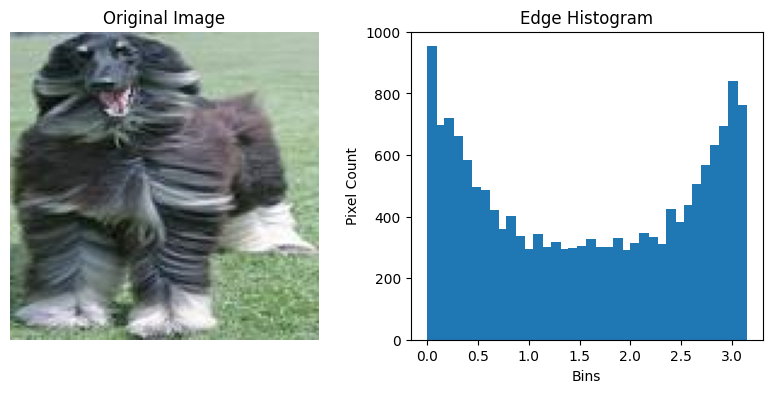

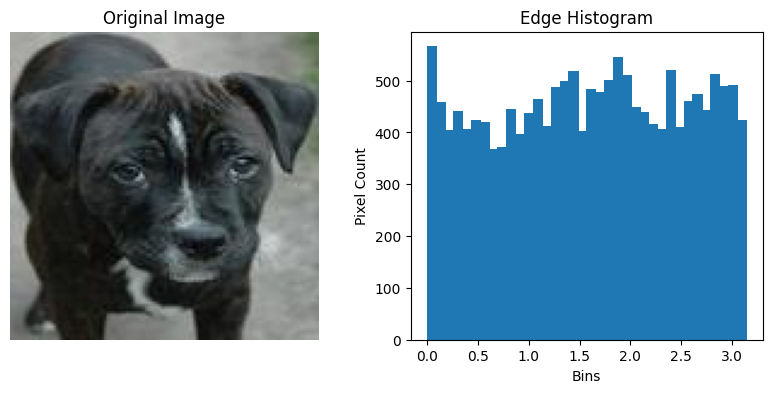

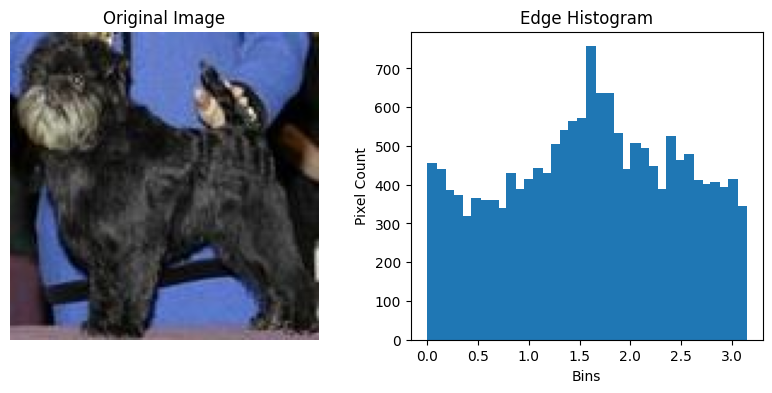

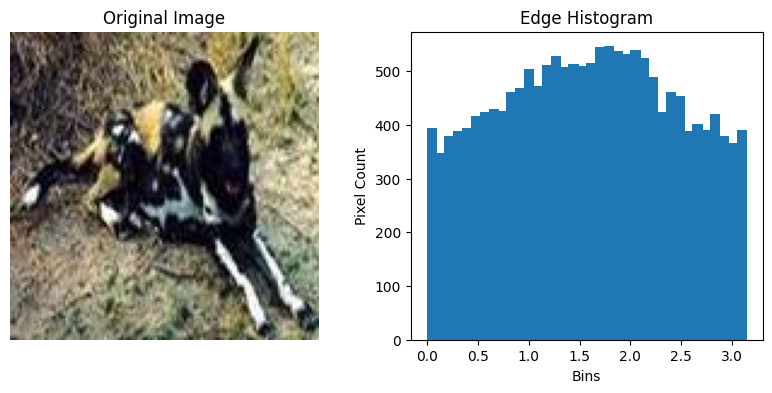

Euclidean Distance: 1064.3880871186036
Manhattan Distance: 5398.0
Cosine Distance: 0.06817054938445688


In [10]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage import filters, exposure
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_distances

# Paths to your cropped images directory
cropped_dir = r"C:\Users\nagal\anaconda3\PA\Cropped"

# Function to convert image to grayscale and compute the edge angle
def compute_edge_histogram(image_path):
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    image_np = np.array(image)

    # Sobel filter to calculate gradient in horizontal and vertical directions
    sobel_h = filters.sobel_h(image_np)
    sobel_v = filters.sobel_v(image_np)

    # Compute the angle of the gradient
    angle = np.mod(np.arctan2(sobel_v, sobel_h), np.pi)

    # Compute the histogram (36 bins)
    hist, hist_centers = exposure.histogram(angle, nbins=36)
    
    return hist, hist_centers

# Function to plot the image and its edge histogram
def plot_edge_histogram(image_path, hist, hist_centers):
    image = Image.open(image_path)
    
    # Plot the image
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    # Plot the histogram
    plt.subplot(1, 2, 2)
    plt.bar(hist_centers, hist, width=0.1)
    plt.title('Edge Histogram')
    plt.xlabel('Bins')
    plt.ylabel('Pixel Count')
    plt.show()

# Process each class, pick one image, and compute histograms
class_folders = ["n02088094-Afghan_hound", "n02093428-American_Staffordshire_terrier", "n02110627-affenpinscher", "n02116738-African_hunting_dog"]
histograms = []
image_paths = []

for class_folder in class_folders:
    folder_path = os.path.join(cropped_dir, class_folder)
    image_files = os.listdir(folder_path)
    
    if image_files:
        # Pick the first image in the class
        image_path = os.path.join(folder_path, image_files[0])
        image_paths.append(image_path)

        # Compute the edge histogram
        hist, hist_centers = compute_edge_histogram(image_path)
        histograms.append(hist)

        # Plot the image and histogram
        plot_edge_histogram(image_path, hist, hist_centers)

# Histogram similarity comparison
# Pick two histograms for comparison
hist1, hist2 = histograms[0], histograms[1]

# Euclidean distance
euclidean_dist = euclidean_distances([hist1], [hist2])[0][0]

# Manhattan distance
manhattan_dist = manhattan_distances([hist1], [hist2])[0][0]

# Cosine distance
cosine_dist = cosine_distances([hist1], [hist2])[0][0]

# Print the distances
print(f"Euclidean Distance: {euclidean_dist}")
print(f"Manhattan Distance: {manhattan_dist}")
print(f"Cosine Distance: {cosine_dist}")


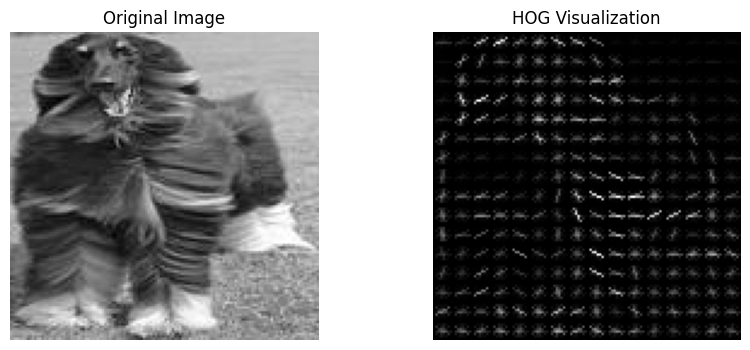

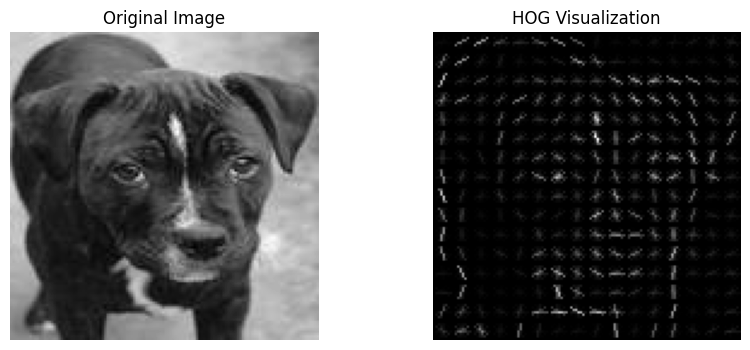

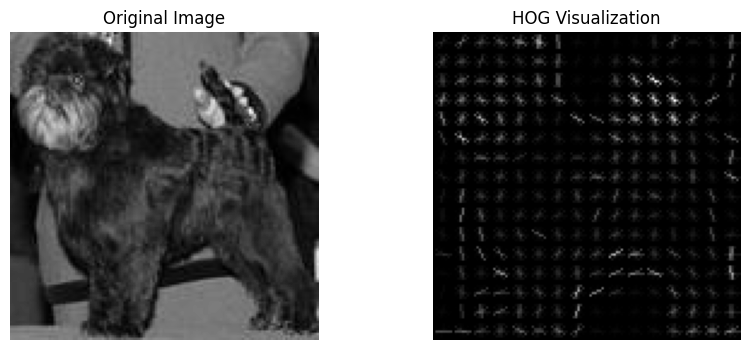

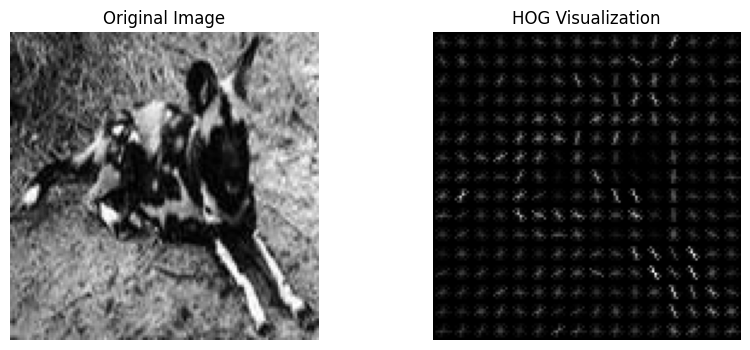

HOG feature vector length for n02088094-Afghan_hound: 8100
HOG feature vector length for n02093428-American_Staffordshire_terrier: 8100
HOG feature vector length for n02110627-affenpinscher: 8100
HOG feature vector length for n02116738-African_hunting_dog: 8100


In [14]:
# Initialize lists to store HOG features and image paths
hog_features_list = []

# Compute HOG for each of the four selected images
for image_path in image_paths:
    hog_features = compute_and_plot_hog(image_path)  # Call the HOG computation and visualization function
    hog_features_list.append(hog_features)  # Store the HOG features

# Print the shapes of the HOG feature vectors
for i, features in enumerate(hog_features_list):
    print(f"HOG feature vector length for {class_folders[i]}: {len(features)}")


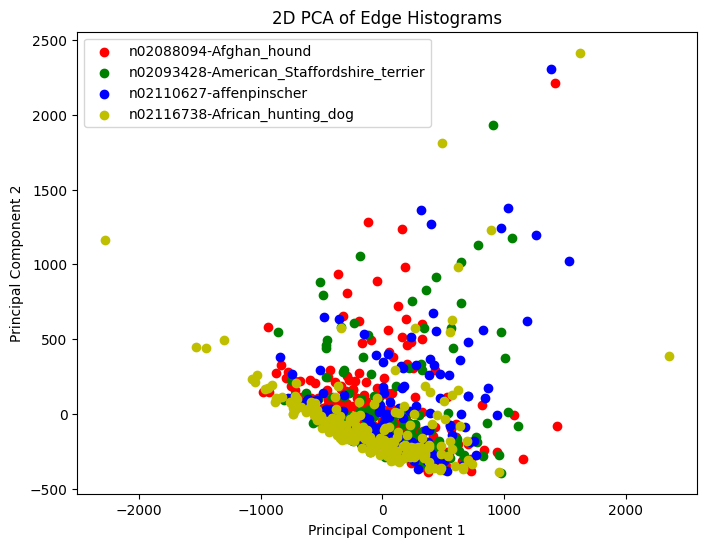

In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage import filters, exposure
from sklearn.decomposition import PCA

# Define the path to your cropped images directory
cropped_dir = r"C:\Users\nagal\anaconda3\PA\Cropped"

# Function to compute edge histogram for an image
def compute_edge_histogram(image_path):
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    image_np = np.array(image)

    # Sobel filter to calculate gradient in horizontal and vertical directions
    sobel_h = filters.sobel_h(image_np)
    sobel_v = filters.sobel_v(image_np)

    # Compute the angle of the gradient
    angle = np.mod(np.arctan2(sobel_v, sobel_h), np.pi)

    # Compute the histogram (36 bins)
    hist, _ = exposure.histogram(angle, nbins=36)
    
    return hist

# Initialize lists to store histograms and image paths
histograms = []
class_folders = ["n02088094-Afghan_hound", "n02093428-American_Staffordshire_terrier", 
                 "n02110627-affenpinscher", "n02116738-African_hunting_dog"]

# Compute histograms for all images in each class
for class_folder in class_folders:
    folder_path = os.path.join(cropped_dir, class_folder)
    image_files = os.listdir(folder_path)
    
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        
        # Compute the edge histogram
        hist = compute_edge_histogram(image_path)
        histograms.append((hist, class_folder))  # Store histogram along with class

# Convert the list of histograms to a NumPy array
histograms_np = np.array([h for h, _ in histograms])

# Perform PCA to reduce the histograms from 36 to 2 dimensions
pca = PCA(n_components=2)
histograms_2d = pca.fit_transform(histograms_np)

# Plot the 2D representation of the histograms
plt.figure(figsize=(8, 6))

# Define colors for each class
colors = {
    'n02088094-Afghan_hound': 'r', 
    'n02093428-American_Staffordshire_terrier': 'g', 
    'n02110627-affenpinscher': 'b', 
    'n02116738-African_hunting_dog': 'y'
}

# Track which classes have been added to the legend
added_classes = set()

# Plot each histogram in the 2D PCA space
for i in range(len(histograms_2d)):
    class_name = histograms[i][1]
    plt.scatter(histograms_2d[i, 0], histograms_2d[i, 1], color=colors[class_name])
    
    # Add to legend only if it's the first occurrence
    if class_name not in added_classes:
        plt.scatter([], [], color=colors[class_name], label=class_name)  # Placeholder for legend
        added_classes.add(class_name)

plt.title('2D PCA of Edge Histograms')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# Analyzing separability
# You can visually inspect how many classes are non-overlapping


              ID                                              Tweet  anger  \
0  2017-En-10853         @jaaames1993 Literally burst out laughing.  False   
1  2017-En-20837  If you really care like you state @flyfrontier...  False   
2  2017-En-11513  bows are world of tank creats rubberbath sting...  False   
3  2017-En-40957  eun: im really unhappy with this and i dont li...   True   
4  2017-En-30720  Light of day per heyday popularization backfir...  False   

   anticipation  disgust   fear    joy   love  optimism  pessimism  sadness  \
0         False    False  False   True  False      True      False    False   
1          True    False  False  False  False      True      False    False   
2         False    False  False  False  False     False      False    False   
3         False     True  False  False  False     False      False     True   
4          True    False  False  False  False     False      False     True   

   surprise  trust  
0      True  False  
1     False  F

C:\Users\nagal\AppData\Local\Temp\ipykernel_29064\2030347092.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['label'] = filtered_data[selected_classes].idxmax(axis=1)


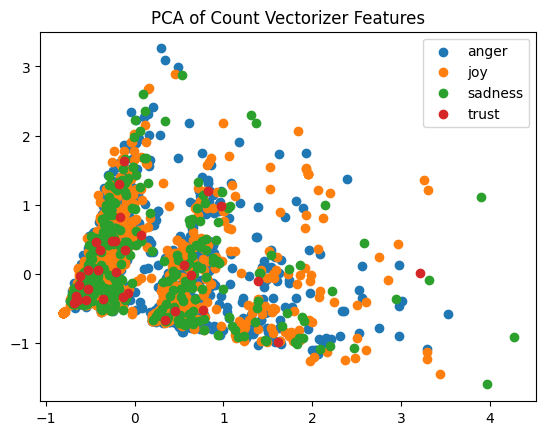

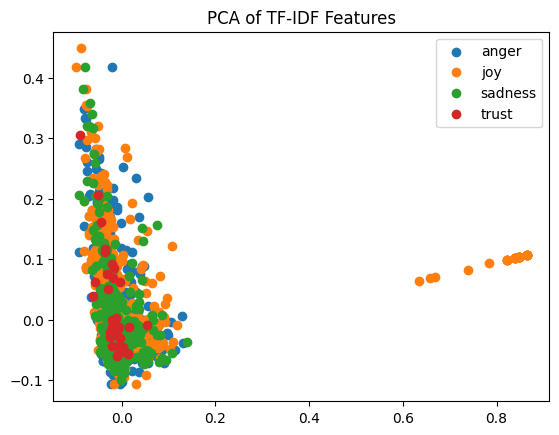

In [16]:
import json
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Load the dataset
def load_dataset(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(json.loads(line))
    return pd.DataFrame(data)

# Example usage
train_set_path = r'C:\Users\nagal\anaconda3\PA\train.json'
train_data = load_dataset(train_set_path)

# Print the first few rows to inspect the structure
print(train_data.head())

# Step 2: Vectorize the text data
count_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()

X_count = count_vectorizer.fit_transform(train_data['Tweet'])  # Update 'tweet' to 'Tweet'
X_tfidf = tfidf_vectorizer.fit_transform(train_data['Tweet'])  # Update 'tweet' to 'Tweet'

# Print the dimensionality of the vector representations
print(f"Count Vectorizer Dimensionality: {X_count.shape}")
print(f"TF-IDF Vectorizer Dimensionality: {X_tfidf.shape}")

# Step 3: Select four classes
selected_classes = ['anger', 'joy', 'sadness', 'trust']
filtered_data = train_data[train_data[selected_classes].any(axis=1)]

# Step 4: Perform PCA
def perform_pca(X):
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(X.toarray())
    return reduced_data

X_count_filtered = count_vectorizer.transform(filtered_data['Tweet'])  # Update 'tweet' to 'Tweet'
X_tfidf_filtered = tfidf_vectorizer.transform(filtered_data['Tweet'])  # Update 'tweet' to 'Tweet'

reduced_count = perform_pca(X_count_filtered)
reduced_tfidf = perform_pca(X_tfidf_filtered)

# Step 5: Plot the results
def plot_pca(reduced_data, labels, title):
    plt.figure()
    for label in np.unique(labels):
        indices = labels == label
        plt.scatter(reduced_data[indices, 0], reduced_data[indices, 1], label=label)
    plt.legend()
    plt.title(title)
    plt.show()

# Create a label column for plotting
filtered_data['label'] = filtered_data[selected_classes].idxmax(axis=1)

plot_pca(reduced_count, filtered_data['label'], 'PCA of Count Vectorizer Features')
plot_pca(reduced_tfidf, filtered_data['label'], 'PCA of TF-IDF Features')

# Determine visually separable classes
# You can manually inspect the plots to determine how many classes are visually separable.
